In [1]:
import csv
import ast
import random
import statistics as st
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
tile_records = []
with open('tiles.csv', newline='') as tiles_csv:
    csv_reader = csv.reader(tiles_csv, delimiter=';')
    for row in csv_reader:
        tile_records.append({'id': row[0], 'visitor': row[1], 'typ': row[2], 'date': row[3], 'data': ast.literal_eval(row[4])})
        
tile_humans = []
tile_h_mouse = []
tile_h_touchpad = []
tile_h_trackball = []
tile_bots = []
tile_b_gc = []  # ghost-cursor
no_input_type = 0
idx = 0
while idx < len(tile_records):
    record = tile_records[idx]
    if record['visitor'] == 'human':
        if record['data']['positions'][0]['x'] == 0:
            tile_records.remove(record)
        else:
            tile_humans.append(record)
            idx += 1
            if record['typ'] == 'mouse':
                tile_h_mouse.append(record)
            elif record['typ'] == 'touchpad':
                tile_h_touchpad.append(record)
            elif record['typ'] == 'trackball':
                tile_h_trackball.append(record)
            else:
                no_input_type += 1
    else:
        tile_bots.append(record)
        idx += 1
        if record['typ'] == 'ghost-cursor':
            tile_b_gc.append(record)
            
            
def check_data(data_list):
    not_valid_idxs = []
    for idx, data in enumerate(data_list):
        last_click_time = data['data']['tileClicks'][-1]['time']
        if last_click_time/20 > len(data['data']['positions']) + 2:
            not_valid_idxs.append(idx)
    return not_valid_idxs


bad_h_idxs = check_data(tile_humans)
bad_humans = [tile_humans[badidx] for badidx in bad_h_idxs]
tile_humans = [tile_humans[idx] for idx, human in enumerate(tile_humans) if idx not in bad_h_idxs]

bad_b_idxs = check_data(tile_bots)
bad_bots = [tile_bots[badidx] for badidx in bad_b_idxs]
tile_bots = [tile_bots[idx] for idx, bot in enumerate(tile_bots) if idx not in bad_b_idxs]
            
print('Adatok száma:')
print('\tEmberek:')
print('\t\tJó adatok száma:', len(tile_humans))
print('\t\tRossz adatok száma:', len(bad_humans))
print('\t\tegér (összesből):', len(tile_h_mouse))
print('\t\térintőpárna (összesből):', len(tile_h_touchpad))
print('\t\ttrackball (összesből):', len(tile_h_trackball))
print('\t\tnincs megadva beviteli eszköz (összesből):', no_input_type)
print('\tBotok:')
print('\t\tJó adatok száma:', len(tile_bots))
print('\t\tRossz adatok száma:', len(bad_bots))
print('\t\tghost-cursor:', len(tile_b_gc))
print('\t------------------------------------')
print('\tÖsszesen:', len(tile_records))

Adatok száma:
	Emberek:
		Jó adatok száma: 56
		Rossz adatok száma: 20
		egér (összesből): 39
		érintőpárna (összesből): 9
		trackball (összesből): 0
		nincs megadva beviteli eszköz (összesből): 28
	Botok:
		Jó adatok száma: 77
		Rossz adatok száma: 0
		ghost-cursor: 77
	------------------------------------
	Összesen: 153


In [3]:
# ember csoportoknak megfelelő számosságú adatsorok a botokból

tile_bots_56 = random.sample(tile_bots, 56)
tile_bots_20 = [bot for bot in tile_bots if bot not in tile_bots_56][:-1]

In [4]:
# egérmozgás animálása

def animate_path(toanim, save_with=''):
    thisx = np.array([pos['x'] for pos in toanim['data']['positions']])
    thisy = np.array([pos['y'] for pos in toanim['data']['positions']])
    tiledim = [toanim['data']['tileDimensions']['width'], toanim['data']['tileDimensions']['height']]
    fig, ax = plt.subplots()
    fig.set_size_inches((6, 6))
    fig.set_tight_layout(True)
    ax.set_aspect('equal')
    
    clicks = toanim['data']['tileClicks']
    clicktimes = [click['time'] for click in clicks]
    clickposes = [click['clickPos'] for click in clicks]
    
    xlim_lo = min(min(thisx),min([click['tilePos']['x'] for click in clicks])) - tiledim[0]/5
    xlim_up = max(max(thisx),max([click['tilePos']['x'] + tiledim[0] for click in clicks]))\
              + tiledim[0]/5
    
    ylim_lo = -max(max(thisy), max([click['tilePos']['y'] + tiledim[1] for click in clicks]))\
              - tiledim[1]/5
    ylim_up = -min(min(thisy), min([click['tilePos']['y'] for click in clicks])) + tiledim[1]/5

    ax.set_xlim((xlim_lo, xlim_up))
    ax.set_ylim((ylim_lo, ylim_up))
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    path, = ax.plot([], [], lw=3, color='r', zorder=1)
    cursor, = ax.plot([], [], 'o', markersize=6, color='r', zorder=1)
    
    for tile in clicks:
        ax.add_patch((Rectangle((tile['tilePos']['x'], -tile['tilePos']['y']),\
                               tiledim[0], -tiledim[1], color='0.8', zorder=0)))


    def animate(frame):
        if len(clicktimes) and frame > clicktimes[0]/20:
            ax.plot(clickposes[len(clickposes)-len(clicktimes)]['x'], -clickposes[len(clickposes)-len(clicktimes)]['y'], \
                    'o', markersize=9, color='b', zorder=2)
            clicktimes.pop(0)
        
        if frame < len(thisx):
            pathx = []
            pathy = []
            if frame < 6:
                linecount = frame
            else:
                linecount = 6
            for i in range(linecount):
                pathx.append(thisx[frame-i])
                pathy.append(-thisy[frame-i])
                path.set_data(pathx, pathy)

            cursorx = pathx[0] if pathx else thisx[0]
            cursory = pathy[0] if pathy else -thisy[0]
            cursor.set_data(cursorx, cursory)
        else:
            path.set_data([], [])
            
        return path, cursor
        
        
    framenum = max(len(thisx), int(max(clicktimes)/20)) + 50
    ani = animation.FuncAnimation(fig, animate, frames=framenum, interval=20, blit=True)
    plt.close()
    display(HTML(ani.to_html5_video()))
    
    ax.clear()
    ax.set_xlim((xlim_lo, xlim_up))
    ax.set_ylim((ylim_lo, ylim_up))
    
    clicktimes = [click['time'] for click in clicks]
    
    path, = ax.plot([], [], lw=3, color='r', zorder=1)
    cursor, = ax.plot([], [], 'o', markersize=6, color='r', zorder=1)
    
    for tile in clicks:
        ax.add_patch((Rectangle((tile['tilePos']['x'], -tile['tilePos']['y']),\
                               tiledim[0], -tiledim[1], color='0.8', zorder=0)))
        
    if save_with:
        ani.save(save_with,'ffmpeg')

# 1. Mousemove eventek

Mousemove eventek:

	Emberek:
		max: 862
		min: 110
		átlag: 207.66071428571428
		medián: 187.0
		korrigált tapasztalati szórás: 110.90360708712349
		kvantilisek: [158.  187.  220.5]
	-----------------------------------------------------
	Botok:
		max: 765
		min: 354
		átlag: 516.5714285714286
		medián: 511.0
		korrigált tapasztalati szórás: 76.40201262052939
		kvantilisek: [464.75 511.   552.  ]


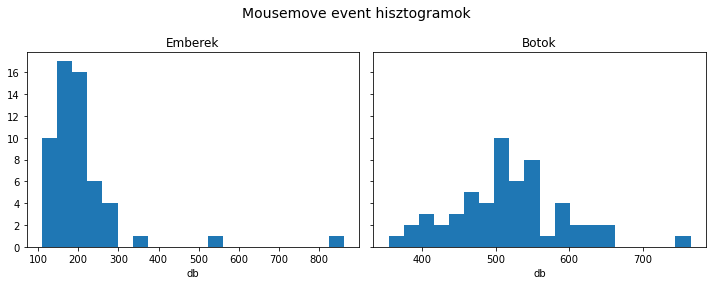

In [5]:
def print_stats(data_array, print_mean=True, num_of_tabs=0):
    print(num_of_tabs*'\t' + f'max: {np.amax(data_array)}')
    print(num_of_tabs*'\t' + f'min: {np.amin(data_array)}')
    if print_mean:
        print(num_of_tabs*'\t' + f'átlag: {np.mean(data_array)}')
    print(num_of_tabs*'\t' + f'medián: {np.median(data_array)}')
    print(num_of_tabs*'\t' + f'korrigált tapasztalati szórás: {np.std(data_array, ddof=1)}')
    print(num_of_tabs*'\t' + f'kvantilisek: {np.quantile(data_array, [0.25, 0.5, 0.75])}')
    
def print_h_and_b(h_data_array, b_data_array, title, print_mean=True, before_h='', before_b='', after_h='', after_b=''):
    print(title +'\n')
    print('\tEmberek:')
    if before_h:
        print(before_h)
    print_stats(h_data_array, print_mean=print_mean, num_of_tabs=2)
    if after_h:
        print(after_h)
    print('\t-----------------------------------------------------')
    print('\tBotok:')
    if before_h:
        print(before_b)
    print_stats(b_data_array, print_mean=print_mean, num_of_tabs=2)
    if after_b:
        print(after_b)
        
def h_and_b_hist(h_data_array, b_data_array, title, xlabel='', bins=20):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    fig.suptitle(title, fontsize=14)
    fig.set_figwidth(10)
    
    if xlabel:
        axs[0].set_xlabel(xlabel)
        axs[1].set_xlabel(xlabel)

    mm_ev_hist_h = axs[0]
    mm_ev_hist_h.hist(h_data_array, bins=bins)
    mm_ev_hist_h.set_title('Emberek')

    mm_ev_hist_b = axs[1]
    mm_ev_hist_b.hist(b_data_array, bins=bins)
    mm_ev_hist_b.set_title('Botok')

mm_events_h = [human['data']['mouseMoveEvents'] for human in tile_humans]
mm_events_b = [bot['data']['mouseMoveEvents'] for bot in tile_bots_56]

print_h_and_b(mm_events_h, mm_events_b, 'Mousemove eventek:')
h_and_b_hist(mm_events_h, mm_events_b, 'Mousemove event hisztogramok', 'db')

Mousemove eventek a kiugró adatok eltávolítása után:

	Emberek:
		eltávolított adatok száma: 2
		max: 371
		min: 110
		átlag: 189.37037037037038
		medián: 185.0
		korrigált tapasztalati szórás: 47.41200241969477
		kvantilisek: [158.   185.   210.75]
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 765
		min: 354
		átlag: 516.5714285714286
		medián: 511.0
		korrigált tapasztalati szórás: 76.40201262052939
		kvantilisek: [464.75 511.   552.  ]


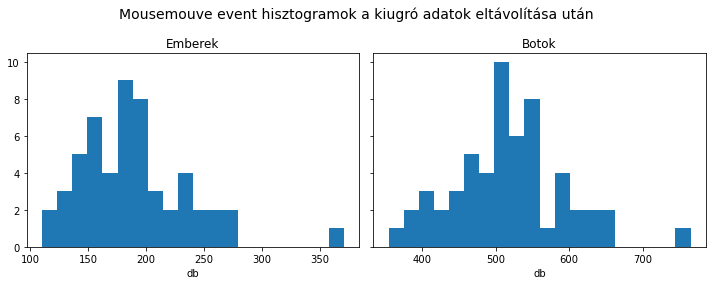

In [6]:
# mousemove event adatsorok kiugró értékeinek eltávolítása

mm_events_h_corr = [mm_event for mm_event in mm_events_h if mm_event < 500]
mm_events_b_corr = mm_events_b

print_h_and_b(mm_events_h_corr, mm_events_b_corr, 'Mousemove eventek a kiugró adatok eltávolítása után:',\
            before_h=f'\t\teltávolított adatok száma: {len(mm_events_h) - len(mm_events_h_corr)}',\
            before_b=f'\t\teltávolított adatok száma: {len(mm_events_b) - len(mm_events_b_corr)}')

h_and_b_hist(mm_events_h_corr, mm_events_b_corr, 'Mousemouve event hisztogramok a kiugró adatok eltávolítása után', 'db')

# 2. Sebességek

## 2.1. Max sebességek

Max sebességek (vp%/s)

	Emberek:
		max: 1300.735552521509
		min: 298.8421053575906
		átlag: 739.9345967171432
		medián: 713.4003801343968
		korrigált tapasztalati szórás: 226.13208340692609
		kvantilisek: [582.88124229 713.40038013 870.72440257]
	-----------------------------------------------------
	Botok:
		max: 1122.81502247482
		min: 193.54633475758945
		átlag: 497.4732128667143
		medián: 437.20974113071316
		korrigált tapasztalati szórás: 233.08672306349334
		kvantilisek: [309.73656588 437.20974113 600.68335768]


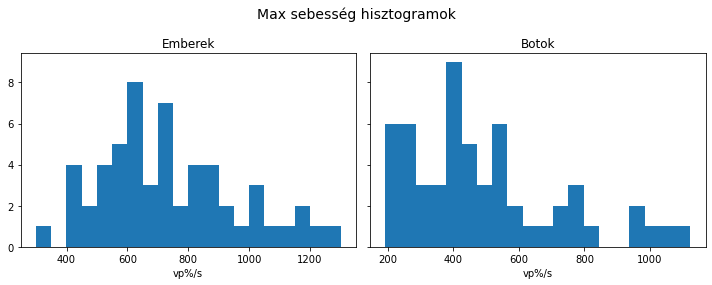

In [7]:
def norm_pos(pos, viewport):
    return {'x': pos['x']/viewport['width'] * 100, 'y': pos['y']/viewport['height'] * 100}

def calculate_distance(pos1, pos2, normed=True, viewport={}):
    if normed:
        pos1_normed = norm_pos(pos1, viewport)
        pos2_normed = norm_pos(pos2, viewport)
        return ((pos1_normed['x'] - pos2_normed['x'])**2 + (pos1_normed['y'] - pos2_normed['y'])**2)**0.5
    else:
        return ((pos1['x'] - pos2['x'])**2 + (pos1['y'] - pos2['y'])**2)**0.5


def calculate_vel(poslist, normed=True, viewport={}, timediv=0.02):
    i = 0
    vel_list = []
    while i < len(poslist) - 1:
        vel_list.append(calculate_distance(poslist[i], poslist[i + 1], normed=normed, viewport=viewport)/timediv)
        i += 1
    return vel_list


human_vels = [calculate_vel(human['data']['positions'], viewport=human['data']['viewport']) for human in tile_humans]
bot_vels = [calculate_vel(bot['data']['positions'], viewport=bot['data']['viewport']) for bot in tile_bots_56]

max_h_vels = [max(human_vel) for human_vel in human_vels]
max_b_vels = [max(bot_vel) for bot_vel in bot_vels]

print_h_and_b(max_h_vels, max_b_vels, 'Max sebességek (vp%/s)')
h_and_b_hist(max_h_vels, max_b_vels, 'Max sebesség hisztogramok', 'vp%/s')

Max sebességek a kiugró adatok eltávolítása után (vp%/s)

	Emberek:
		eltávolított adatok száma: 0
		max: 1300.735552521509
		min: 298.8421053575906
		átlag: 739.9345967171432
		medián: 713.4003801343968
		korrigált tapasztalati szórás: 226.13208340692609
		kvantilisek: [582.88124229 713.40038013 870.72440257]
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 1122.81502247482
		min: 193.54633475758945
		átlag: 497.4732128667143
		medián: 437.20974113071316
		korrigált tapasztalati szórás: 233.08672306349334
		kvantilisek: [309.73656588 437.20974113 600.68335768]


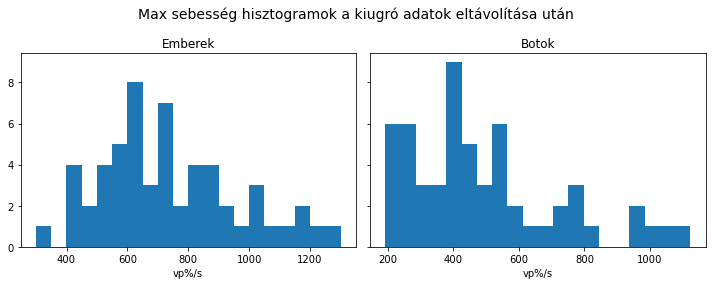

In [8]:
# max sebesség adatsorok kiugró értékeinek eltávolítása

max_h_vels_corr = max_h_vels
max_b_vels_corr = [max_vel for max_vel in max_b_vels if max_vel < 1500]

print_h_and_b(max_h_vels_corr, max_b_vels_corr, 'Max sebességek a kiugró adatok eltávolítása után (vp%/s)',\
            before_h=f'\t\teltávolított adatok száma: {len(max_h_vels) - len(max_h_vels_corr)}',\
            before_b=f'\t\teltávolított adatok száma: {len(max_b_vels) - len(max_b_vels_corr)}')

h_and_b_hist(max_h_vels_corr, max_b_vels_corr, 'Max sebesség hisztogramok a kiugró adatok eltávolítása után', 'vp%/s')

## 2.2. Átlag sebességek

Átlag sebességek (vp%/s)

	Emberek:
		max: 95.55711269784203
		min: 21.156678004297135
		medián: 58.058088217791976
		korrigált tapasztalati szórás: 18.07113862667833
		kvantilisek: [45.84686603 58.05808822 71.05169841]
		Az összes emberre számolt átlag sebesség: 52.82326739297918
	-----------------------------------------------------
	Botok:
		max: 29.23478073127341
		min: 15.629108629532347
		medián: 21.887466597679982
		korrigált tapasztalati szórás: 3.056511994100126
		kvantilisek: [20.19927042 21.8874666  24.30352531]
		Az összes botra számolt átlag sebesség: 22.038325903027218


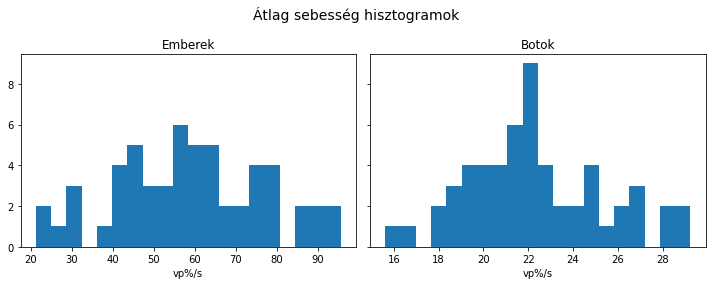

In [9]:
avg_h_vels = [st.mean(human_vel) for human_vel in human_vels]
avg_b_vels = [st.mean(bot_vel) for bot_vel in bot_vels]

h_vel_num = 0
avg_h_vel_all = 0
for all_vels, avg_vel in zip(human_vels, avg_h_vels):
    h_vel_num += len(all_vels)
    avg_h_vel_all += avg_vel * len(all_vels)
avg_h_vel_all /= h_vel_num

b_vel_num = 0
avg_b_vel_all = 0
for all_vels, avg_vel in zip(bot_vels, avg_b_vels):
    b_vel_num += len(all_vels)
    avg_b_vel_all += avg_vel * len(all_vels)
avg_b_vel_all /= b_vel_num
    

print_h_and_b(avg_h_vels, avg_b_vels, 'Átlag sebességek (vp%/s)', print_mean=False,\
            after_h=f'\t\tAz összes emberre számolt átlag sebesség: {avg_h_vel_all}',\
            after_b=f'\t\tAz összes botra számolt átlag sebesség: {avg_b_vel_all}')

h_and_b_hist(avg_h_vels, avg_b_vels, 'Átlag sebesség hisztogramok', 'vp%/s')

# 3. A pálya hatékonysága

Az egérmozgások hatékonysága (%)

	Emberek:
		max: 99.76796827532992
		min: 79.86971857082808
		átlag: 94.82641113088592
		medián: 96.06900169280908
		korrigált tapasztalati szórás: 4.445440810180142
		kvantilisek: [92.01568361 96.06900169 98.54960678]
	-----------------------------------------------------
	Botok:
		max: 98.7344541213854
		min: 77.23937540772204
		átlag: 88.9845251784354
		medián: 89.25126231413843
		korrigált tapasztalati szórás: 4.3444438026509005
		kvantilisek: [86.26764829 89.25126231 91.11225266]


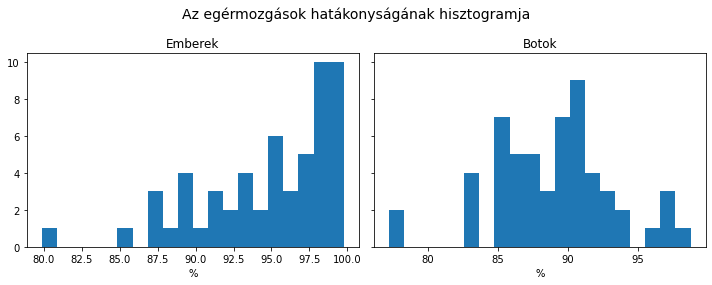

In [10]:
# az elmozdulás és a megtett távolság arányából számoljuk

def calculate_efficiency(pos_list, start_point, end_point, viewport):
    displacement = calculate_distance(start_point, end_point, viewport=viewport)
    traveled_dist = []
    i = 0
    while i < len(pos_list)-1:
        traveled_dist.append(calculate_distance(pos_list[i], pos_list[i+1],viewport=viewport))
        i += 1
    return displacement/sum(traveled_dist) * 100



eff_per_h = []
for human in tile_humans:
    viewport_h = human['data']['viewport']
    clicks_h = [click for click in human['data']['tileClicks']]
    pos_h = human['data']['positions']
    i = 0
    eff_per_click = []
    while i < len(clicks_h) - 1:
        first_click = clicks_h[i]
        second_click = clicks_h[i+1]
        pos_bw_clicks = pos_h[int(first_click['time']/20):int(second_click['time']/20)]
        eff_per_click.append(calculate_efficiency(pos_bw_clicks, first_click['clickPos'], second_click['clickPos'], viewport=viewport_h))
        i+=1
    eff_per_h.append(st.mean(eff_per_click))
    
eff_per_b = []
for bot in tile_bots_56:
    viewport_b = bot['data']['viewport']
    clicks_b = [click for click in bot['data']['tileClicks']]
    pos_b = bot['data']['positions']
    i = 0
    eff_per_click = []
    while i < len(clicks_b) - 1:
        first_click = clicks_b[i]
        second_click = clicks_b[i+1]
        pos_bw_clicks = pos_b[int(first_click['time']/20):int(second_click['time']/20)]
        eff_per_click.append(calculate_efficiency(pos_bw_clicks, first_click['clickPos'], second_click['clickPos'], viewport=viewport_b))
        i+=1
    eff_per_b.append(st.mean(eff_per_click))

print_h_and_b(eff_per_h, eff_per_b, 'Az egérmozgások hatékonysága (%)')

h_and_b_hist(eff_per_h, eff_per_b, 'Az egérmozgások hatákonyságának hisztogramja', '%')

# 4. Kattintások átlagos távolsága a csempék középpontjától

A kattintások távolsága a csempék kp-jától (tile%)

	Emberek:
		max: 31.455101082180494
		min: 12.073334652527407
		átlag: 20.368104281906014
		medián: 19.907541249822614
		korrigált tapasztalati szórás: 4.083854094063353
		kvantilisek: [17.30789274 19.90754125 23.44399277]
	-----------------------------------------------------
	Botok:
		max: 49.932589471932936
		min: 22.244119608490262
		átlag: 38.19305266313397
		medián: 39.2881844179883
		korrigált tapasztalati szórás: 5.0960012675598705
		kvantilisek: [34.25103812 39.28818442 41.84856356]


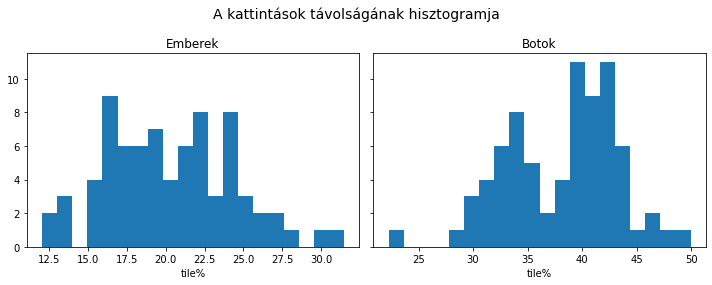

In [11]:
dist_per_h = []
for human in tile_humans+bad_humans:
    clicks_h = [click for click in human['data']['tileClicks']]
    tiledims_h = human['data']['tileDimensions']

    dist_per_click = []
    for click in clicks_h:
        center = {'x': click['tilePos']['x'] + tiledims_h['width']/2, 'y': click['tilePos']['y'] + tiledims_h['height']/2}
        dist_per_click.append(calculate_distance(click['clickPos'], center, viewport=tiledims_h))
    dist_per_h.append(st.mean(dist_per_click))
    
dist_per_b = []
for bot in tile_bots_56+tile_bots_20:
    clicks_b = [click for click in bot['data']['tileClicks']]
    tiledims_b = bot['data']['tileDimensions']

    dist_per_click = []
    for click in clicks_b:
        center = {'x': click['tilePos']['x'] + tiledims_b['width']/2, 'y': click['tilePos']['y'] + tiledims_h['height']/2}
        dist_per_click.append(calculate_distance(click['clickPos'], center, viewport=tiledims_b))
    dist_per_b.append(st.mean(dist_per_click))
    
print_h_and_b(dist_per_h, dist_per_b, 'A kattintások távolsága a csempék kp-jától (tile%)')

h_and_b_hist(dist_per_h, dist_per_b, 'A kattintások távolságának hisztogramja', 'tile%')

# 5.  Egyéb grafikus ábrázolások

In [12]:
def plot_vel(to_plot):
    time = [idx*0.02 for idx, pos in enumerate(to_plot['data']['positions'])][:-1]
    plt.plot(time, calculate_vel(to_plot['data']['positions'], viewport=to_plot['data']['viewport']))
    plt.xlabel('idő (s)')
    plt.ylabel('sebesség (vp%/s)')